In [2]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model


In [3]:
image_path = '../test/sentinel2_visual.tif'
model_path = '../models/2025-01-21_16-22-22.keras'
output_dir = '../output'
SIZE = 128
THRESHOLD = 0.4

In [4]:
image = np.asarray(Image.open(image_path)).astype('float')/255.

h, w = image.shape[:2]

print(f"Image dimensions: {h} x {w}")

n_h = int(np.ceil(h / SIZE))
n_w = int(np.ceil(w / SIZE))

print(f"Number of tiles: {n_h} x {n_w}")

padded_h = n_h * SIZE
padded_w = n_w * SIZE

padded_image = np.zeros((padded_h, padded_w, 3))
padded_image[:h, :w, :] = image

print(f"Padded image dimensions: {padded_h} x {padded_w}")

tiles = []
positions = []
for i in range(n_h):
    for j in range(n_w):
        start_h = i * SIZE
        start_w = j * SIZE
        tile = padded_image[start_h:start_h + SIZE, start_w:start_w + SIZE].copy()
        tiles.append(tile)
        positions.append((start_h, start_w))


print(f"Created {len(tiles)} tiles")

/home/yifan/.local/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image dimensions: 10980 x 10980
Number of tiles: 86 x 86
Padded image dimensions: 11008 x 11008
Created 7396 tiles


In [5]:
model = load_model(model_path)

I0000 00:00:1737506336.576107    7501 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9542 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [6]:
predictions = []
for tile in tqdm(tiles):
    tile_batch = np.expand_dims(tile, 0)
    pred = model.predict(tile_batch, verbose=0)
    predictions.append(pred[0])

  0%|          | 0/7396 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1737506338.496514    7631 service.cc:148] XLA service 0x7f422800cbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737506338.496533    7631 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-21 16:38:58.504950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737506338.541923    7631 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-21 16:38:58.636020: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}

In [7]:
full_image = np.zeros((padded_h, padded_w))
for pred, (start_h, start_w) in zip(predictions, positions):
    full_image[start_h:start_h + SIZE, start_w:start_w + SIZE] = pred.reshape(SIZE, SIZE)

# Crop back to original size
full_prediction = full_image[:h, :w]

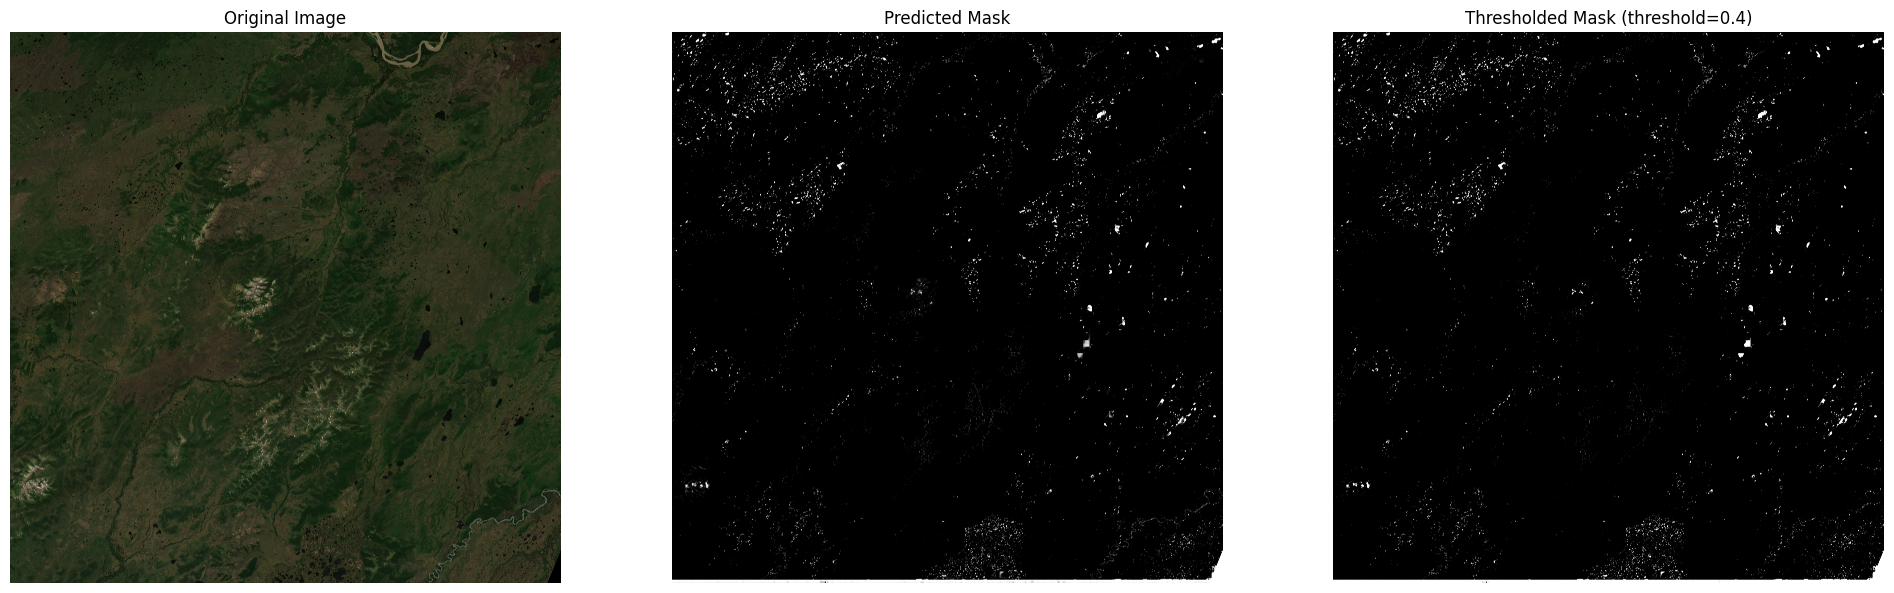

In [8]:

threshold_mask = full_prediction > THRESHOLD
    
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(full_prediction, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(threshold_mask, cmap='gray')
plt.title(f'Thresholded Mask (threshold={THRESHOLD})')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Save the masks with correct orientation
base_filename = os.path.splitext(os.path.basename(image_path))[0]

# Save predicted mask
predicted_mask_path = os.path.join(output_dir, f'{base_filename}_predicted_mask.png')
plt.imsave(predicted_mask_path, 
          full_prediction, 
          cmap='gray',
          vmin=0,
          vmax=1)
print(f"Saved predicted mask to: {predicted_mask_path}")

# Save thresholded mask
thresholded_mask_path = os.path.join(output_dir, f'{base_filename}_thresholded_mask.png')
plt.imsave(thresholded_mask_path, 
          threshold_mask, 
          cmap='gray')
print(f"Saved thresholded mask to: {thresholded_mask_path}")

Saved predicted mask to: output/sentinel2_visual_predicted_mask.png
Saved thresholded mask to: output/sentinel2_visual_thresholded_mask.png
